In [52]:
first_run = False

In [53]:
if first_run:
    import os
    from pathlib import Path
    import torch
    from tqdm import tqdm
    import warnings
    import re
    import keras
    import librosa
    import tensorflow as tf
    import numpy as np
    from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
    import random
    import soundfile as sf
    import shutil

### Use cuda acceleration (optional)

In [54]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Remove existing augmented data

In [55]:

path = './AUDIO_DATA'

if os.path.exists('./augmented_train_dataset'):
    shutil.rmtree('./augmented_train_dataset')

if os.path.exists('./augmented_test_dataset'):
    shutil.rmtree('./augmented_test_dataset')

### Link your google drive storage if you are working on google colab (optional)  

In [56]:
# path = '<your google drive path>'
# from google.colab import drive
# drive.mount('/content/drive')
# %cd /content/drive/MyDrive/DurianAudios

In [57]:
# seed = 41
# random.seed(seed), np.random.seed(seed), tf.random.set_seed(seed)

In [58]:
AUDIO_PATH = Path("./AUDIO_DATA")
assert AUDIO_PATH.exists(), f"Audio path {AUDIO_PATH} does not exist."
AUDIO_LIST = list(AUDIO_PATH.glob("*"))
print(*AUDIO_LIST)

AUDIO_DATA\20240929_023338_Dona_75-85%output.wav AUDIO_DATA\20240929_023344_Dona_75-85%output.wav AUDIO_DATA\20240929_023348_Dona_75-85%output.wav AUDIO_DATA\20240929_023353_Dona_75-85%output.wav AUDIO_DATA\20240929_023359_Dona_75-85%output.wav AUDIO_DATA\20240929_023409_Dona_75-85%output.wav AUDIO_DATA\20240929_023414_Dona_75-85%output.wav AUDIO_DATA\20240929_023418_Dona_75-85%output.wav AUDIO_DATA\20240929_023426_Dona_75-85%output.wav AUDIO_DATA\20240929_023431_Dona_75-85%output.wav AUDIO_DATA\20240929_023435_Dona_75-85%output.wav AUDIO_DATA\20240929_023439_Dona_75-85%output.wav AUDIO_DATA\20240929_023443_Dona_75-85%output.wav AUDIO_DATA\20240929_023447_Dona_75-85%output.wav AUDIO_DATA\20240929_023501_Dona_75-85%output.wav AUDIO_DATA\20240929_023505_Dona_75-85%output.wav AUDIO_DATA\20240929_023509_Dona_75-85%output.wav AUDIO_DATA\20240929_023513_Dona_75-85%output.wav AUDIO_DATA\20240929_023517_Dona_75-85%output.wav AUDIO_DATA\20240929_023521_Dona_75-85%output.wav AUDIO_DATA\20240929_

## Filter audios by label

In [59]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="PySoundFile failed.*")

audios_75_85: list[Path] = []
audios_95: list[Path] = []

def tri_audio(audio: Path):
  if(audio.name not in [*audios_75_85,*audios_95]):
    try:
      if(re.split('_|%',audio.name)[3] == "75-85"):
        audios_75_85.append(audio)
      else:
        audios_95.append(audio)
    except:
      print(audio.name)
for i in sorted(AUDIO_LIST):
  tri_audio(i)

len(audios_75_85), len(audios_95)

(45, 47)

In [60]:
from sklearn.model_selection import train_test_split

# Séparer la liste AUDIO_LIST en train et test avant toute data augmentation
train_files, test_files = train_test_split(audios_95 + audios_75_85, test_size=0.2, random_state=42, shuffle=True)
# train_files_2, test_files_2 = train_test_split(audios_75_85, test_size=0.2, random_state=42, shuffle=True)

# train_files = train_files_1 + train_files_2
# random.shuffle(train_files)
# test_files = test_files_1 + test_files_2
print(f"{len(train_files)} training files and {len(test_files)} testing files.")

73 training files and 19 testing files.


In [61]:
train_files = [Path(i) for i in train_files]
test_files = [Path(i) for i in test_files]
assert False not in [i.exists() for i in train_files], "Some training files do not exist."
assert False not in [i.exists() for i in test_files], "Some testing files do not exist."

In [62]:
len([f for f in train_files if "95" in f.name]), len([f for f in train_files if "75-85" in f.name])

(35, 38)

# **2. Data Augmentation**
---

In [63]:
augment = [
    AddGaussianNoise(min_amplitude=0.000001, max_amplitude=0.00001, p=0.5),
    TimeStretch(min_rate=0.99, max_rate=1.01, p=0.5),
    PitchShift(min_semitones=-0.1, max_semitones=0.1, p=0.5),
]

composed = Compose(augment)

In [64]:
out_train_path = Path("./augmented_train_dataset")

In [65]:
os.mkdir(out_train_path)

In [66]:
def augment_audio(audio_path, output_path, augmentations, use_one=True, nb_copies=10):
    print("loading audios...")
    for file_path, (wave, sr) in tqdm([(audio, librosa.load(audio)) for audio in audio_path], desc="Augmenting audios"):
        for nb in range(nb_copies):
            chosen_aug = random.choice(augmentations) if use_one else composed
            wave_aug = chosen_aug(samples=wave, sample_rate=sr)  # type: ignore
            out = output_path / f"{file_path.name}_aug{nb}.wav"
            sf.write(out, wave_aug, sr)

In [67]:
augment_audio(train_files, out_train_path, augment, use_one=True, nb_copies=2)

loading audios...


Augmenting audios: 100%|██████████| 73/73 [00:02<00:00, 28.93it/s]


In [68]:
out_test_path = Path("./augmented_test_dataset")
os.mkdir(out_test_path)

In [69]:
augment_audio(test_files, out_test_path, augment, use_one=True, nb_copies=1)

loading audios...


Augmenting audios: 100%|██████████| 19/19 [00:00<00:00, 47.51it/s]


# **3. Data and features extraction : MFCC**
---

In [70]:

# Liste des fichiers augmentés
augmented_train_files = sorted(Path(out_train_path).glob("*.wav"))
augmented_test_files = sorted(Path(out_test_path).glob("*.wav"))

# Les fichiers originaux du train
# train_files_names = [Path(f).name for f in train_files]
# Les fichiers du test
# test_files_names = [Path(f).name for f in test_files]
# Liste complète des fichiers d'entraînement (originaux + augmentés)
train_files_final = augmented_train_files + train_files
test_files_final = augmented_test_files + test_files


### Assert all path are correct

In [71]:
assert False not in list(map(lambda x: x.exists(), test_files_final))  
assert False not in list(map(lambda x: x.exists(), train_files_final))

In [72]:

print(f"{len(train_files_final)} train files")
print(f"{len(test_files_final)} test files")

219 train files
38 test files


In [73]:
from typing import Iterable


n_mfcc     = 40        # number of coefficients
n_fft      = 2048      # window size STFT
hop_length = 512

def compute_mfcc(files: Iterable[Path]) -> Iterable[np.ndarray]:
  for file in files:
      y, sr = librosa.load(file, sr=None)
      mfcc_features = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
      yield librosa.util.normalize(mfcc_features, axis=1)

In [74]:
mfcc_test = [*compute_mfcc(tqdm(test_files_final))]
mfcc_train = [*compute_mfcc(tqdm(train_files_final))]

100%|██████████| 219/219 [00:14<00:00, 14.94it/s] 


# **4. Audio dataset preparation (padding and trimming)**
---

Besides, the idea is to set a single length T_max (typically the maximum recorded value) and then, for each MFCC:  
*   If T_i < T_max → pad with columns of trailing zeros
*   If T_i > T_max → trim to keep only the first T_max frames  

In [75]:
# Pour le train
T_train = [mfcc.shape[1] for mfcc in mfcc_train]
print("Durée (train) :", *T_train)

# Pour le test
T_test = [mfcc.shape[1] for mfcc in mfcc_test]
print("Durée (test) :", *T_test)

# T_max commun pour le padding (on prend le max des deux)
T_max = max(T_train)
print(f'The maximum value of time is {T_max} ms')

Durée (train) : 122 122 122 122 129 129 129 129 134 134 134 134 137 137 124 124 123 123 121 121 137 137 122 122 120 120 124 124 136 136 131 131 122 122 122 122 134 134 124 124 123 123 131 131 136 136 134 134 136 136 124 124 132 132 128 128 132 132 122 122 123 123 128 128 124 124 123 123 137 137 131 131 111 111 125 125 134 134 123 123 136 136 134 134 136 136 128 128 134 134 123 123 124 124 123 123 123 123 136 136 137 137 128 128 136 136 128 128 123 123 137 137 125 125 129 129 133 133 134 134 136 136 123 123 130 130 123 123 133 133 124 124 122 122 134 134 123 123 123 123 124 124 124 124 124 124 262 264 268 268 246 271 248 244 246 271 266 271 248 246 250 244 244 248 255 271 246 250 255 255 221 268 264 262 248 246 246 268 246 262 248 271 246 248 248 273 257 257 273 244 271 239 248 266 273 241 244 259 246 268 246 273 248 271 255 268 244 268 246 268 273 268 271 246 248 244 246 255 257
Durée (test) : 125 136 133 121 134 134 128 130 130 101 122 122 136 131 134 123 133 134 134 246 259 271 271 2

In this step, we ensure that all MFCCs have the same length by either padding them with zeros or trimming them to a fixed length, `T_max`. This is necessary to standardize the input size for the model.

In [76]:
def pad_mfccs(mfcc_list, T_max):
    mfcc_fixed = []
    for m in mfcc_list:
        T_i = m.shape[1]
        if T_i < T_max:
            pad_width = T_max - T_i
            m2 = np.pad(m,
                        pad_width=((0,0),   # no padding sur les coefficients
                        (0,pad_width)),     # padding à droite sur le temps
                        mode='constant',
                        constant_values=0)
        else:
            m2 = m[:, :T_max]
        mfcc_fixed.append(m2)
    return mfcc_fixed

# Pour le train
mfcc_train_fixed = pad_mfccs(mfcc_train, T_max)

# Pour le test
mfcc_test_fixed = pad_mfccs(mfcc_test, T_max)


# **5. Dataset formatting for model input**
---
At this stage, we will prepare our padded/truncated MFCCs into the right shape for our deep learning model (flattening, stacking, or reshaping as needed), and associate them with their corresponding labels.


In [77]:
x_train = np.stack(mfcc_train_fixed, axis=0)[..., np.newaxis]
x_test = np.stack(mfcc_test_fixed, axis=0)[..., np.newaxis]

print("X_train.shape =", x_train.shape)
print("X_test.shape =", x_test.shape)


X_train.shape = (219, 40, 273, 1)
X_test.shape = (38, 40, 273, 1)


In [78]:
len(mfcc_test_fixed)

38

# **6. Label and shuffle**
---

In [79]:
import re

def get_label(filename):
    base_name = re.sub(r'_aug\d+\.wav$', '', filename)
    if "75-85" in base_name:
        return 0  # unripe
    elif "95" in base_name:
        return 1  # ripe
    else:
        raise ValueError(f"Le nom de fichier ne permet pas d'extraire le label : {filename}")

# Recreate y_train and y_test with the new function
y_train = np.array([get_label(f) for f in map(lambda x: x.name, train_files_final)])
y_test = np.array([get_label(f) for f in map(lambda x: x.name, test_files_final)])

# Use class weight (optional, but useful for imbalanced datasets)
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

In [80]:
class_weights_dict

{0: np.float64(0.9605263157894737), 1: np.float64(1.042857142857143)}

Shuffle training data ton ensure linear accuracy progress during training

In [81]:
# Shuffle le train pour éviter tout biais
idx = np.arange(x_train.shape[0])
np.random.shuffle(idx)
x_train = x_train[idx]
y_train = y_train[idx]
train_files_final = [train_files_final[i] for i in idx]# type: ignore

In [82]:
len([i for i in y_train if i == 0]), len([i for i in y_train if i == 1])

(114, 105)

### Ensure label corresponds to file name

In [83]:
assert False not in [bool(int("95" in i.name) == j) for i, j in zip(train_files_final, y_train)]

# **7. Building the classification model**
---
Now let's define our deep learning model. We'll use a simple Convolutional Neural Network (CNN) architecture suitable for audio classification.


In [84]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Input, BatchNormalization, Dropout, MaxPooling2D, Flatten
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
from sklearn.utils import class_weight
from keras.utils import plot_model


In [85]:
model = Sequential([
    Input(shape=x_train.shape[1:]),
    Conv2D(32, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.25),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(1e-4)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [86]:
plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True, show_layer_activations=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [87]:
def compile_model(model, learning_rate: int | None = None):
    if learning_rate is not None:
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
        model.compile(
            optimizer=opt,
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        return opt
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

In [88]:
compile_model(model)

# **6. Model training**
---
Let's train the model on the training data and keep track of its performance.


In [89]:
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
history = model.fit(
    x_train, y_train,
    epochs=15,
    batch_size=8,
    validation_split=0.2,
    callbacks=[es, reduce_lr],
    shuffle=True,
    class_weight=class_weights_dict  # Add class weights to compensate for slight class imbalance
)

Epoch 1/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.4787 - loss: 12.9520 - val_accuracy: 0.6818 - val_loss: 0.5999 - learning_rate: 0.0010
Epoch 2/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.5658 - loss: 4.3343 - val_accuracy: 0.6364 - val_loss: 0.7927 - learning_rate: 0.0010
Epoch 3/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.6685 - loss: 1.3883 - val_accuracy: 0.6591 - val_loss: 0.8911 - learning_rate: 0.0010
Epoch 4/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.6873 - loss: 0.6666 - val_accuracy: 0.6591 - val_loss: 0.8736 - learning_rate: 0.0010
Epoch 5/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.6810 - loss: 0.7278 - val_accuracy: 0.7500 - val_loss: 0.9859 - learning_rate: 2.0000e-04
Epoch 6/15
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - accuracy: 0.6408 - loss: 0.5870 - val_accuracy: 0.7273 - val_loss: 1.1222 - learning_rate: 2.0000e-04


In [90]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((219, 40, 273, 1), (219,), (38, 40, 273, 1), (38,))

In [91]:
def show_confusion_matrix(x, y_real):
    y_prob = model.predict(x).ravel()
    y_pred = (y_prob >= 0.5).astype(int)
    cm = confusion_matrix(y_real, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Unripe', 'Ripe'], yticklabels=['Unripe', 'Ripe'])
    plt.xlabel("Prediction")
    plt.ylabel("Reality")
    plt.title("Confusion matrix")
    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step


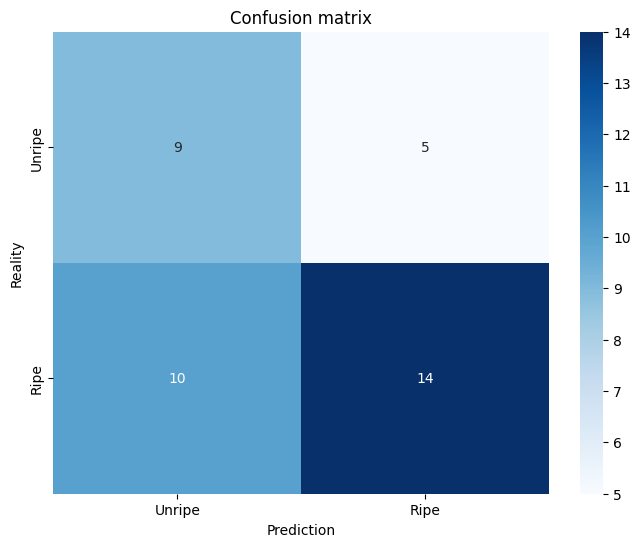

In [92]:
show_confusion_matrix(x_test, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


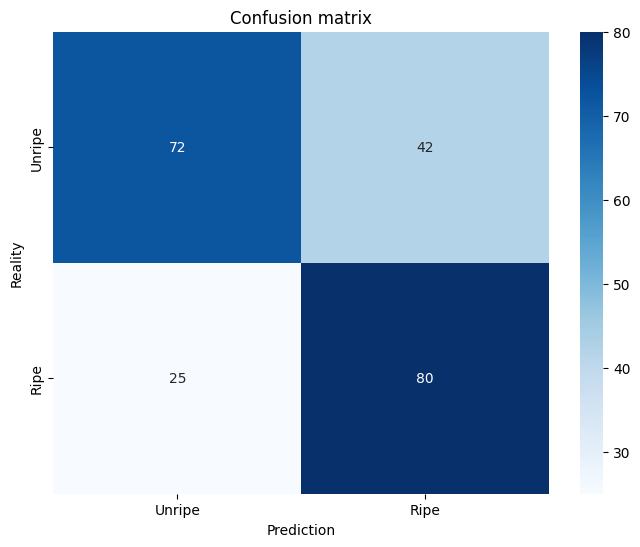

In [102]:
show_confusion_matrix(x_train, y_train)

# **7. Model evaluation**
---
We now evaluate the trained model on the test set, check the accuracy, and display a confusion matrix for detailed analysis.


In [94]:
loss, acc = model.evaluate(x_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6118 - loss: 0.6928


# **8. Results & analysis**
---
Let's analyze the results, discuss strengths and weaknesses, and try to interpret what the model is learning.


In [95]:
print("X_train.shape:", x_train.shape)
print("y_train.shape:", y_train.shape)
print("X_test.shape:", x_test.shape)
print("y_test.shape:", y_test.shape)

print("Répartition y_train :", np.unique(y_train, return_counts=True))
print("Répartition y_test :", np.unique(y_test, return_counts=True))

print("Premier fichier train:", train_files_final[0].name, "label:", y_train[0])
print("Premier fichier test:", test_files_final[0].name, "label:", y_test[0])

X_train.shape: (219, 40, 273, 1)
y_train.shape: (219,)
X_test.shape: (38, 40, 273, 1)
y_test.shape: (38,)
Répartition y_train : (array([0, 1]), array([114, 105]))
Répartition y_test : (array([0, 1]), array([14, 24]))
Premier fichier train: 20240929_024345_Dona_95-Ripeoutput.wav_aug1.wav label: 1
Premier fichier test: 20240929_023348_Dona_75-85%output.wav_aug0.wav label: 0


In [96]:
print("y_train repartition :", np.bincount(y_train))
print("y_test repartition :", np.bincount(y_test))

y_train repartition : [114 105]
y_test repartition : [14 24]


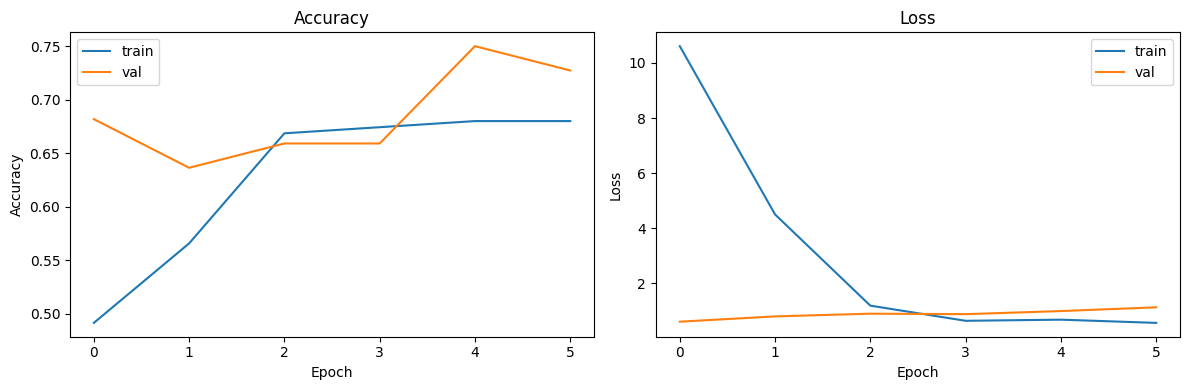

In [97]:
plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


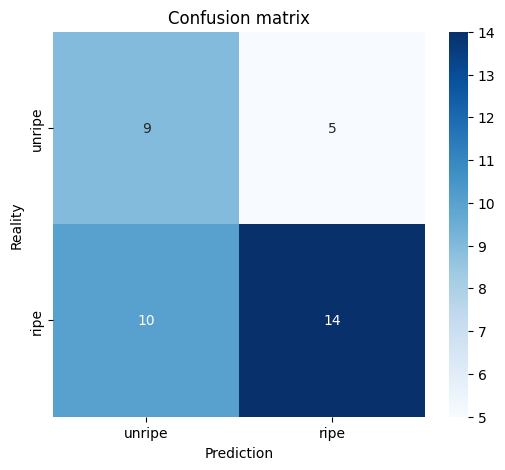

In [98]:

# Confusion matrix
y_prob = model.predict(x_test).ravel()
y_pred = (y_prob >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)
labels = ['unripe', 'ripe']

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Prediction")
plt.ylabel("Reality")
plt.title("Confusion matrix")
plt.show()


In [99]:

print(classification_report(y_test, y_pred, target_names=labels))



              precision    recall  f1-score   support

      unripe       0.47      0.64      0.55        14
        ripe       0.74      0.58      0.65        24

    accuracy                           0.61        38
   macro avg       0.61      0.61      0.60        38
weighted avg       0.64      0.61      0.61        38



# **9. Save model**
---
Finally, we save our trained model for later use, and discuss possible improvements or future work.


In [100]:
# only execute the first time 
# model_version_index = 5

In [103]:
model.save(f"models/model_augmented_v{model_version_index}_({loss:.2f}, {acc:.2f})_.keras")
model_version_index+=1

test